# Analyse IMDB Movie Data for Title Segmentation & Reccomendation
[Cloud Guru Challenge - October 2020](https://theclouddevopslearningblog.com/aws/sagemaker/2020/11/05/cloud-guru-challenge-2.html)

## Introduction
This notebook performs steps 2-5 of October Cloud Guru Challenge as listed here: https://acloudguru.com/blog/engineering/cloudguruchallenge-machine-learning-on-aws

The data used is the IMDB datasets. These can be accessed here: https://datasets.imdbws.com/

Some of the primary libraries used:
* Pandas library for loading and transforming the data (including one-hot-encoding descriptive attributes)
* Sklearn library for scaling and pre-training preparation
* AWS Sagemaker - PCA (for dimension reduction) and KMeans (for k-means cluster analysis)
* MatPlotLib and Seaborn for plotting and exploratory data analysis

Analysis steps based on the following AWS blog:
https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/

## Dependencies
Some libraries may need to be installed before using

In [9]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install boto3

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install sagemaker

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install mxnet

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import io
import gzip
import mxnet as mx
import os
import boto3
import sagemaker

from sklearn.preprocessing import MinMaxScaler
from sagemaker import get_execution_role
from sagemaker import PCA
from sagemaker import KMeans

%matplotlib inline
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

## Data Loading
Load the basic title info, alternate title info and title rating info into data frames

In [14]:
def remoteImdbToDf(dataset):
    url="https://datasets.imdbws.com/" + dataset + ".tsv.gz"
    content=requests.get(url).content
    open(dataset + '.tsv.gz', 'wb').write(content)
    
    with gzip.open(dataset + '.tsv.gz', 'rb') as read_file:
        file_content = read_file.read()
        write_file = open(dataset + '.tsv', 'wb')
        write_file.write(file_content)
        write_file.close()
    
    return pd.read_csv(dataset + '.tsv', sep='\t')
    

In [15]:
df_titleakas = remoteImdbToDf('title.akas')

In [16]:
df_titlebasics = remoteImdbToDf('title.basics')

In [17]:
df_titleratings = remoteImdbToDf('title.ratings')

## Exploratory data analysis EDA – Data cleaning and exploration

In [18]:
df_titlebasics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7327684 entries, 0 to 7327683
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 503.2+ MB


In [19]:
# make the column names lower case to make it easier to work with
df_titlebasics.columns = ['titleid','type','title','originaltitle','isadult','startyear','endyear','length','genres']

In [20]:
df_titlebasics.head()

,titleid,type,title,originaltitle,isadult,startyear,endyear,length,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [21]:
# we're probably only going to want titles that are movies for the recommendation, let's check this field does that
df_titlebasics[df_titlebasics['type']=='movie'].sample(5)

,titleid,type,title,originaltitle,isadult,startyear,endyear,length,genres
66937,tt0068281,movie,Black Gunn,Black Gunn,0,1972,\N,96,"Action,Crime,Thriller"
3724171,tt2172584,movie,Maps to the Stars,Maps to the Stars,0,2014,\N,111,"Comedy,Drama"
6515605,tt8197070,movie,Into the Heavens,Into the Heavens,0,\N,\N,\N,"Action,Adventure,Fantasy"
31223,tt0031776,movie,The Pal from Texas,The Pal from Texas,0,1939,\N,56,Western
2994528,tt1410270,movie,Cinderella Moon,Little Sister,0,2010,\N,\N,\N


In [22]:
# make the column names lower case to make it easier to work with
df_titleakas.columns = ['titleid','ordering','title','region','language','types','attributes','isoriginaltitle']

In [23]:
df_titleakas.sample(5)

,titleid,ordering,title,region,language,types,attributes,isoriginaltitle
12173849,tt1991229,1,The Wrong Line,US,\N,\N,\N,0
15257724,tt3941314,1,Episodio #1.9130,IT,it,\N,\N,0
19862824,tt7369334,5,एपिसोड #1.44,IN,hi,\N,\N,0
16186422,tt4606578,7,Episodio #1.35,ES,es,\N,\N,0
16904625,tt5118486,1,Suhani,US,\N,\N,\N,0


In [24]:
# merge the basic and alternate info data frames on the title id field
df_titlesfull = pd.merge(left=df_titlebasics, right=df_titleakas, left_on='titleid', right_on='titleid')

In [25]:
# we don't need this data anymore, all required info is in the new data frame
del df_titlebasics
del df_titleakas

In [26]:
df_titlesfull.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5,Карменсита,RU,\N,imdbDisplay,\N,0
5,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",6,Carmencita,US,\N,\N,\N,0
6,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",7,Carmencita,\N,\N,original,\N,1
7,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",8,カルメンチータ,JP,ja,imdbDisplay,\N,0
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1
9,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0


In [27]:
df_titleratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089164 entries, 0 to 1089163
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1089164 non-null  object 
 1   averageRating  1089164 non-null  float64
 2   numVotes       1089164 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.9+ MB


In [28]:
# make the column names lower case to make it easier to work with
df_titleratings.columns = ['titleid', 'averagerating', 'numvotes']

(array([  3828.,   8198.,  18273.,  38935.,  86864., 171416., 280141.,
        297961., 150263.,  33285.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

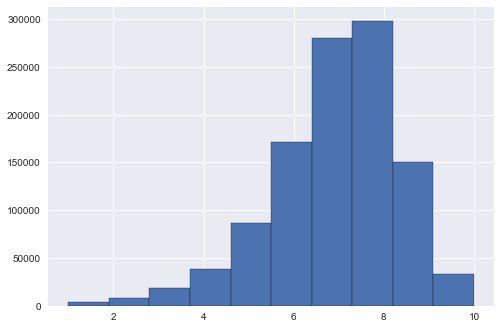

In [29]:
# let's check out the frequency of each rating
plt.hist(df_titleratings['averagerating'], edgecolor='black')

In [30]:
df_titleratings.sample(5)

,titleid,averagerating,numvotes
216611,tt0396930,7.0,5
489901,tt1124040,3.9,884
617836,tt1638057,7.8,36
160325,tt0271118,6.8,8
847123,tt4384398,6.1,202


In [31]:
# merge the title info and ratings data frames on the title id field
df_titles = pd.merge(left=df_titlesfull, right=df_titleratings, left_on='titleid', right_on='titleid')

In [32]:
# we don't need this data anymore, all required info is in the new data frame
del df_titleratings
del df_titlesfull

In [33]:
df_titles.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0,5.6,1657
1,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",2,Carmencita,DE,\N,\N,literal title,0,5.6,1657
2,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0,5.6,1657
3,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0,5.6,1657
4,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5,Карменсита,RU,\N,imdbDisplay,\N,0,5.6,1657
5,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",6,Carmencita,US,\N,\N,\N,0,5.6,1657
6,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",7,Carmencita,\N,\N,original,\N,1,5.6,1657
7,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",8,カルメンチータ,JP,ja,imdbDisplay,\N,0,5.6,1657
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1,6.1,202
9,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0,6.1,202


In [34]:
df_titles.shape

(2985856, 18)

In [35]:
# the titles get duplicated if it's moved language/region, etc. Let's only consider original titles to remove bias
df_titles = df_titles.drop_duplicates(subset=['titleid'])

In [36]:
df_titles.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0,5.6,1657
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1,6.1,202
16,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",1,Sarmanul Pierrot,RO,\N,imdbDisplay,\N,0,6.5,1370
25,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",1,Un bon bock,\N,\N,original,\N,1,6.2,122
33,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",10,Blacksmith Scene,\N,\N,original,\N,1,6.2,2157
44,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short,1,Китайский опиумный притон,RU,\N,imdbDisplay,\N,0,5.3,115
50,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport",1,Corbett and Courtney Before the Kinetograph,US,\N,\N,\N,0,5.4,661
59,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short",10,Edison kinetoskopische Aufnahme eines Niesens,DE,\N,\N,literal title,0,5.4,1825
69,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,1,Miss Jerry,\N,\N,original,\N,1,5.9,155
73,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",10,Радници напуштају фабрику Лимијер,RS,\N,imdbDisplay,\N,0,6.9,6080


In [37]:
df_titles.shape

(812301, 18)

In [38]:
# now let's get only movies
df_titles = df_titles[df_titles['type']=='movie']

In [39]:
df_titles.shape

(254748, 18)

In [40]:
df_titles.head()

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
69,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,1,Miss Jerry,\N,\N,original,\N,1,5.9,155
998,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",1,Early Christian Martyrs,AU,\N,working,\N,0,6.0,39
1406,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,1,Bohemios,ES,\N,\N,\N,0,4.7,7
1545,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",1,Kelly bandájának története,HU,\N,imdbDisplay,\N,0,6.1,595
1634,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,1,Robbery Under Arms,AU,\N,\N,\N,0,4.5,14


In [41]:
#df_title = df_titles[df_titles['isoriginaltitle'] == 1]

In [42]:
#df_titles.head()

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
69,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,1,Miss Jerry,\N,\N,original,\N,1,5.9,155
998,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",1,Early Christian Martyrs,AU,\N,working,\N,0,6.0,39
1406,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,1,Bohemios,ES,\N,\N,\N,0,4.7,7
1545,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",1,Kelly bandájának története,HU,\N,imdbDisplay,\N,0,6.1,595
1634,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,1,Robbery Under Arms,AU,\N,\N,\N,0,4.5,14


In [43]:
# let's drop some of the columns that won't contribute much to the clustering
#  (reconsider region later if needed, obviously need to one-hot-encode it and remove \N values)
df_titles.drop(['originaltitle','ordering','title_y','type',
                'types','region','types','attributes',
                'isoriginaltitle','endyear'],axis=1,inplace=True)

In [44]:
df_titles.shape

(254748, 9)

In [45]:
df_titles.head()

,titleid,title_x,isadult,startyear,length,genres,language,averagerating,numvotes
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155
998,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.0,39
1406,tt0000502,Bohemios,0,1905,100,\N,\N,4.7,7
1545,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,595
1634,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14


In [46]:
# make the column names lower case to make it easier to work with, rename some columns due to merge naming
df_titles.columns = ['titleid', 'title', 'isadult',
                     'year','length','genres',
                     'language','averagerating',
                     'numvotes']

In [47]:
df_titles.head()

,titleid,title,isadult,year,length,genres,language,averagerating,numvotes
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155
998,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.0,39
1406,tt0000502,Bohemios,0,1905,100,\N,\N,4.7,7
1545,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,595
1634,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14


In [48]:
df_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254748 entries, 69 to 2985833
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   titleid        254748 non-null  object 
 1   title          254748 non-null  object 
 2   isadult        254748 non-null  int64  
 3   year           254748 non-null  object 
 4   length         254748 non-null  object 
 5   genres         254748 non-null  object 
 6   language       254748 non-null  object 
 7   averagerating  254748 non-null  float64
 8   numvotes       254748 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 19.4+ MB


In [49]:
# let's not consider any titles that don't have a valid year value
df_titles = df_titles[(df_titles['year']!='\\N')]

In [50]:
#  convert the year value (string) to integer for easy scaling and comparison
df_titles['year'] = df_titles['year'].astype(int)

<BarContainer object of 126 artists>

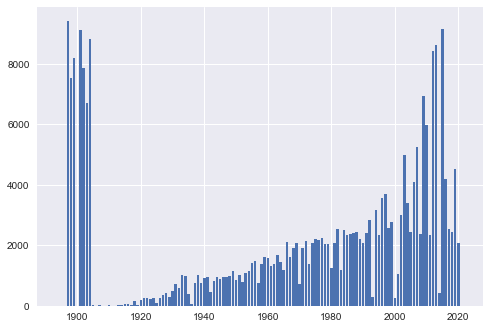

In [51]:
# let's check how many titles are there for each year
plt.bar(df_titles.year.unique(),
        df_titles.year.value_counts().sort_index())

Text(0, 0.5, 'average rating of movie')

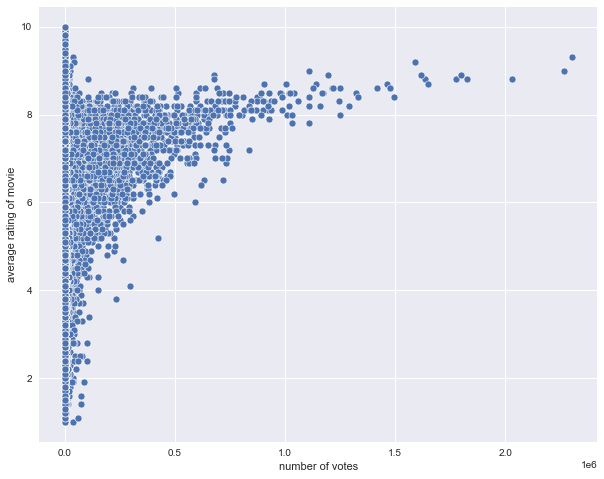

In [52]:
# and check out if there's a relationship between number of votes and the average rating
plt.figure(figsize = (10,8))
sns.scatterplot(x = df_titles['numvotes'], y = df_titles['averagerating'])
plt.xlabel('number of votes')
plt.ylabel('average rating of movie')

Text(0.5, 0, 'year')

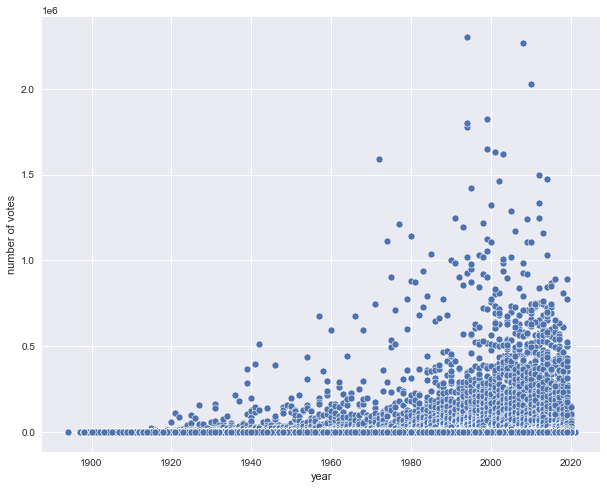

In [53]:
# plot number of votes per movie based on year of release
plt.figure(figsize = (10,8))
sns.scatterplot(x = df_titles['year'], y = df_titles['numvotes'])
plt.ylabel('number of votes')
plt.xlabel('year')

## Data modelling

The 'genres' column contains non-numerical comma-separated-values for zero, one or multiple genres for the title. To make this value comparible (and useful for clustering), this needs to be made into a numerical (0 or 1) for each value. To do this, we need to use a process called 'one-hot-encoding' 

In [54]:
# we can see there's lots of unique values, as each genre can be combined with others
df_titles.genres.unique()

array(['Romance', 'Biography,Drama', '\\N', ..., 'Fantasy,History,War',
       'Documentary,Family,Sci-Fi', 'Horror,Musical,Thriller'],
      dtype=object)

In [55]:
df_titles.genres.unique().shape

(1256,)

In [56]:
df_titles.shape

(254729, 9)

In [57]:
# let's convert the csv column to a pandas list object in a new column
df_titles['genres_list'] = df_titles.genres.str.split(',').tolist()
df_titles.head()

,titleid,title,isadult,year,length,genres,language,averagerating,numvotes,genres_list
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155,[Romance]
998,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.0,39,"[Biography, Drama]"
1406,tt0000502,Bohemios,0,1905,100,\N,\N,4.7,7,[\N]
1545,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,595,"[Biography, Crime, Drama]"
1634,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14,[Drama]


In [58]:
df_titles.shape

(254729, 10)

In [59]:
# get the one hot encoded values for genre. 
# (this table is relatively sparse)
genres_one_hot_encoded = df_titles.genres_list.str.join('|').str.get_dummies().add_prefix('genre_')

In [60]:
genres_one_hot_encoded.head()

,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western,genre_\N
69,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
998,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1545,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1634,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
genres_one_hot_encoded.shape

(254729, 29)

In [62]:
# let's add these new columns to the original full data
df_titles = pd.concat([df_titles, genres_one_hot_encoded], axis=1, sort=False)

In [63]:
# get the one hot encoded values for language. 
language_one_hot_encoded = pd.get_dummies(df_titles.language, prefix='language')
language_one_hot_encoded.head()

,language_\N,language_af,language_ar,language_az,language_bg,language_bn,language_bs,language_ca,language_cmn,language_cs,...,language_te,language_th,language_tl,language_tr,language_uk,language_ur,language_yi,language_yue,language_zh,language_zu
69,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1406,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1634,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# let's add these new columns to the original full data
df_titles = pd.concat([df_titles, language_one_hot_encoded], axis=1, sort=False)

In [65]:
# now we can drop the descriptive value columns, and the one-hot-encoded columns for null values
df_titles.drop(['genres','language','genres_list','genre_\\N','language_\\N'],axis=1,inplace=True)

In [66]:
df_titles.titleid.unique().shape

(254729,)

In [67]:
df_titles.titleid.shape

(254729,)

In [68]:
df_titles.title.unique().shape

(228063,)

In [69]:
df_titles.title.shape

(254729,)

In [70]:
# We can now set the ‘titleid and title’ 
#   as the index and the rest of the numerical 
#   features become the attributes of each unique title.
df_titles.index=df_titles['titleid'] + " " + df_titles['title']
df_titles.drop(['titleid','title'],axis=1,inplace=True)

In [71]:
# Let's get rid of titles where the length value isn't available
df_titles = df_titles[df_titles['length'] != '\\N']

# and conver the length to integer for scale/comparison ease
df_titles['length'] = df_titles['length'].astype(int)

In [72]:
# Remove some really short/long titles, lowly rated, and old movies
df_titles = df_titles[
    (df_titles['length'] > 30) & 
    (df_titles['length'] < 360) &  
    (df_titles['numvotes'] > 50000) &
    (df_titles['year'] > 1960) &
    (df_titles['averagerating'] > 5.0)
]

### Feature engineering

In [73]:
# Data Scaling – We need to standardize the scaling of the numerical columns 
#   in order to use any distance based analytical methods so that we can 
#   compare the relative distances between different feature columns. We can 
#   use minmaxscaler to transform the numerical columns so that they also 
#   fall between 0 and 1.
scaler=MinMaxScaler()
df_titles_scaled=pd.DataFrame(scaler.fit_transform(df_titles))
df_titles_scaled.columns=df_titles.columns
df_titles_scaled.index=df_titles.index

In [74]:
df_titles_scaled.describe()

,isadult,year,length,averagerating,numvotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,...,language_te,language_th,language_tl,language_tr,language_uk,language_ur,language_yi,language_yue,language_zh,language_zu
count,3187.0,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.0,3187.00000,3187.000000,3187.000000,...,3187.000000,3187.000000,3187.000000,3187.000000,3187.0,3187.000000,3187.0,3187.000000,3187.0,3187.0
mean,0.0,0.731116,0.195769,0.433188,0.061749,0.331660,0.0,0.25353,0.059931,0.075306,...,0.000314,0.001255,0.000314,0.026985,0.0,0.000314,0.0,0.001569,0.0,0.0
std,0.0,0.195246,0.079873,0.184985,0.092315,0.470883,0.0,0.43510,0.237396,0.263926,...,0.017714,0.035411,0.017714,0.162064,0.0,0.017714,0.0,0.039584,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,0.0,0.644068,0.139535,0.309524,0.010572,0.000000,0.0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
50%,0.0,0.779661,0.182171,0.428571,0.028750,0.000000,0.0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
75%,0.0,0.881356,0.236434,0.571429,0.073719,1.000000,0.0,1.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0


In [75]:
df_titles_scaled.shape

(3187, 95)

In [76]:
# Get the current service/execution role (ensure it has Sagemaker execute permissions)
try:
    role = get_execution_role()
except:
    role = 'arn:aws:iam::955966247963:role/service-role/AmazonSageMaker-ExecutionRole-20201024T195844'

Couldn't call 'get_role' to get Role ARN from role name simon2 to get Role path.


In [77]:
role

'arn:aws:iam::955966247963:role/service-role/AmazonSageMaker-ExecutionRole-20201024T195844'

In [78]:
bucket_name='movies-bucket-s3bucket-1la82ft02b7le'

In [79]:
num_components=94

pca_SM = PCA(role=role,
          instance_count=1,
          instance_type='ml.c4.xlarge',
          output_path='s3://'+ bucket_name +'/titles/',
            num_components=num_components)

In [80]:
#convert the numerical values to 32 bit floats for consistancy
train_data = df_titles_scaled.values.astype('float32')

In [81]:
%%time
# We call the fit function on our PCA model, passing in our training data, 
# and this spins up a training instance or cluster to perform the training job.
pca_SM.fit(pca_SM.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-12 04:20:24 Starting - Starting the training job...
2020-11-12 04:20:25 Starting - Launching requested ML instances......
2020-11-12 04:21:29 Starting - Preparing the instances for training......
2020-11-12 04:22:54 Downloading - Downloading input data
2020-11-12 04:22:54 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/12/2020 04:23:09 INFO 140192640415552] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[11/12/2020 04:23:09 INFO 140192640415552] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'95', u'mini_batch_size': u'500', u'num_compone


2020-11-12 04:23:18 Uploading - Uploading generated training model
2020-11-12 04:23:18 Completed - Training job completed
Training seconds: 30
Billable seconds: 30
CPU times: user 697 ms, sys: 77 ms, total: 774 ms
Wall time: 3min 16s


In [82]:
job_name=pca_SM._current_job_name
job_name

'pca-2020-11-12-04-20-23-813'

In [83]:
# Get the model artifacts from S3 after they have been trained
model_key = "titles/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [84]:
# load the ND array using MXNet
pca_model_params = mx.ndarray.load('model_algo-1')

In [85]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [86]:
#We can now calculate the variance explained by the largest n components that we want to keep. 
# For this example, let's take the top 20 components.
#We can see that the largest 20 components explain ~91% of the total variance in our dataset:
s.iloc[75:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.911247
dtype: float32

In [87]:
s_20=s.iloc[74:,:]
v_20=v.iloc[:,74:]
v_20.columns=[0,1,2,3,4,5,6,7,8,
              9,10,11,12,13,14,
              15,16,17,18,19]

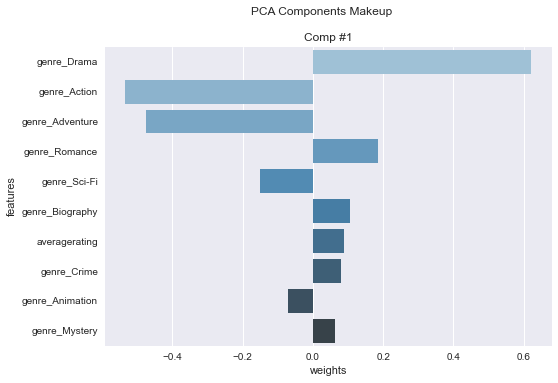

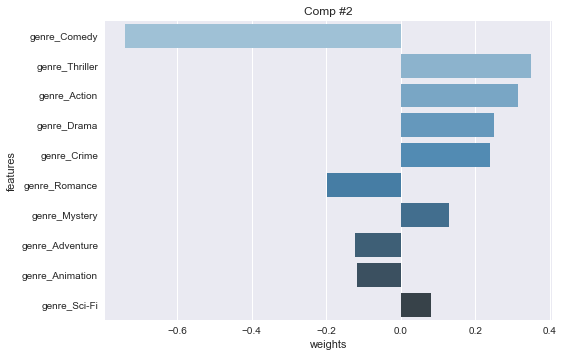

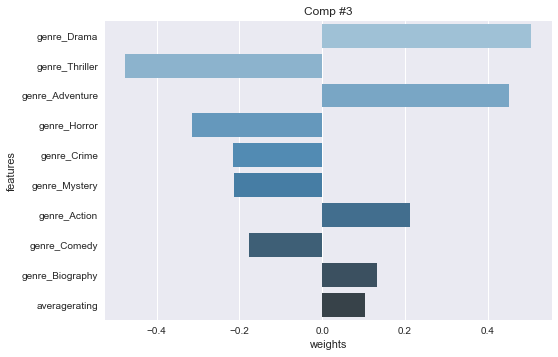

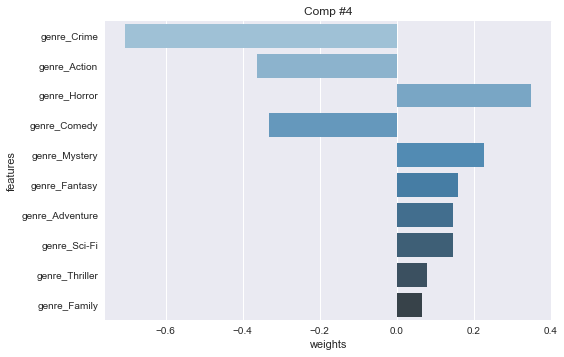

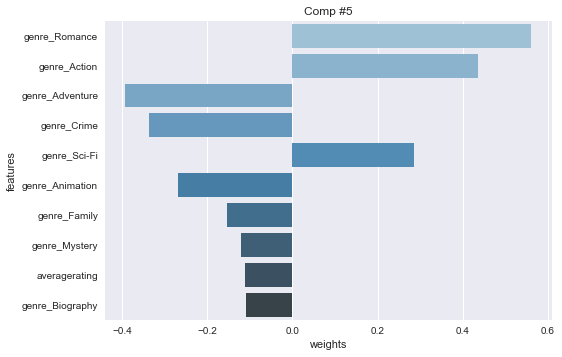

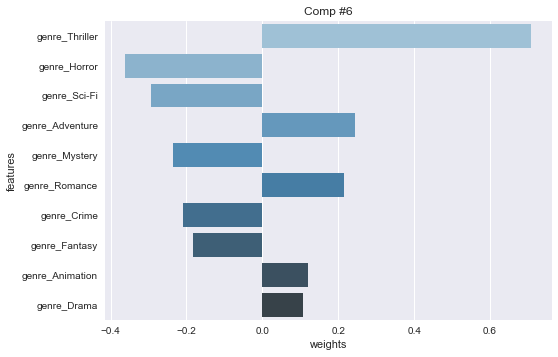

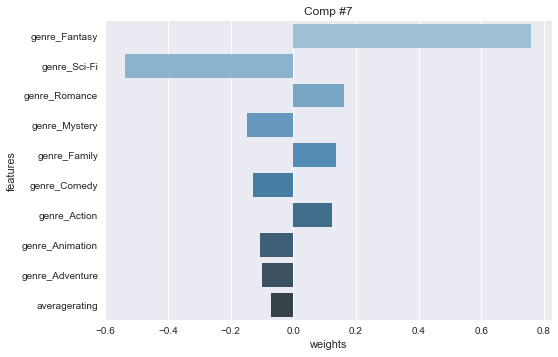

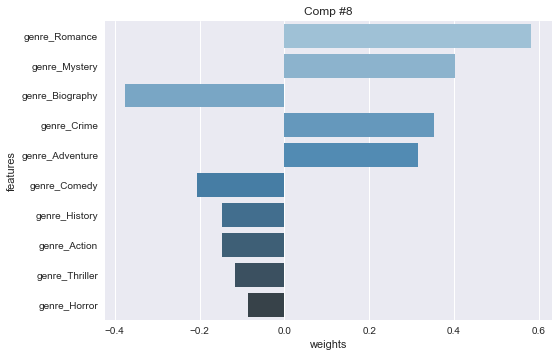

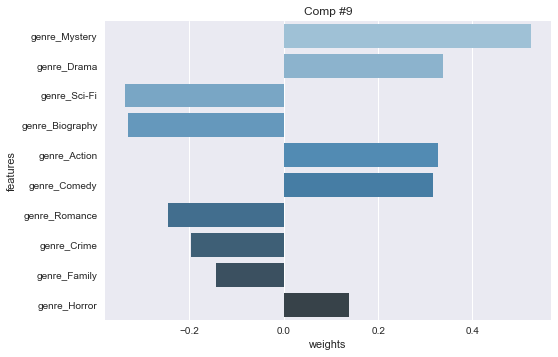

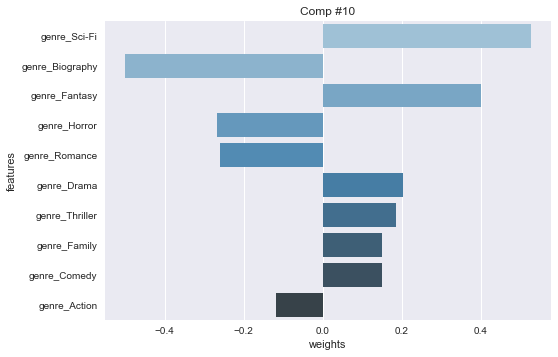

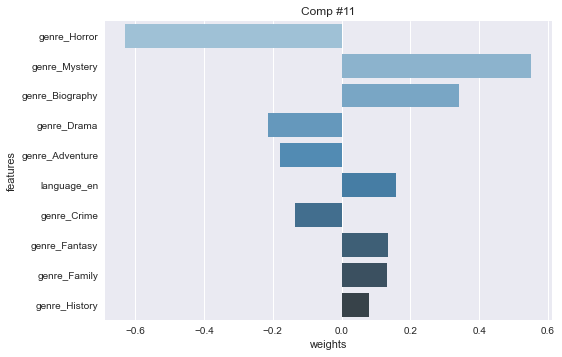

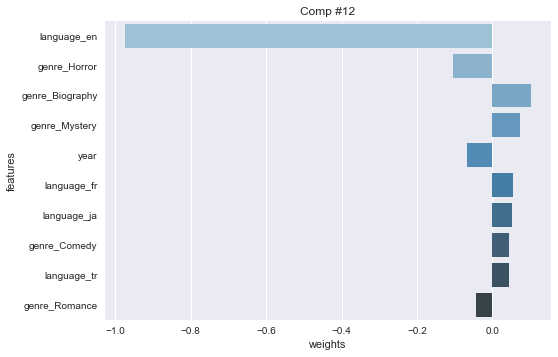

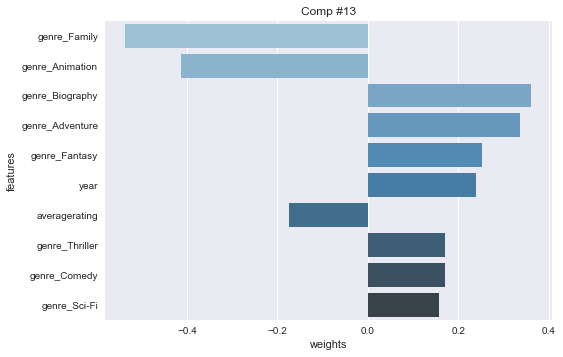

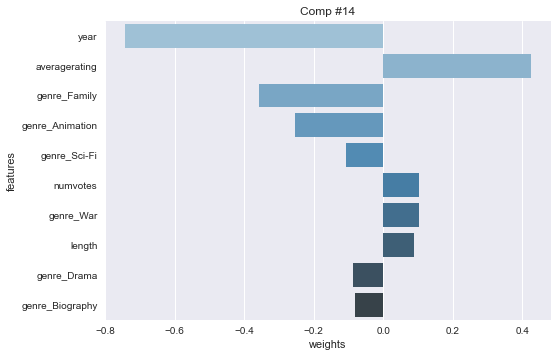

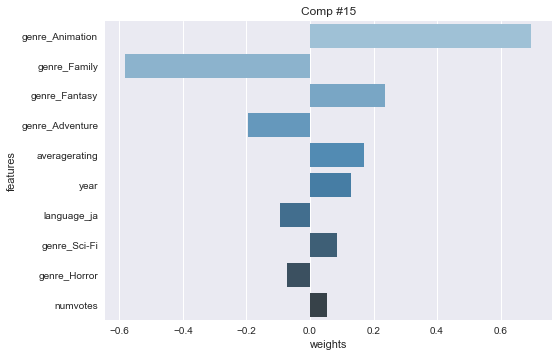

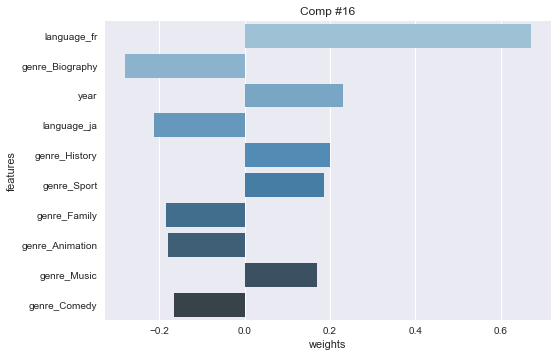

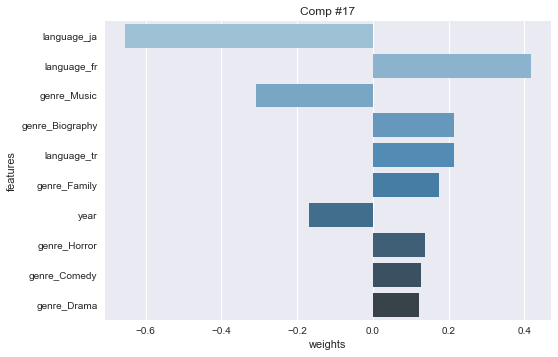

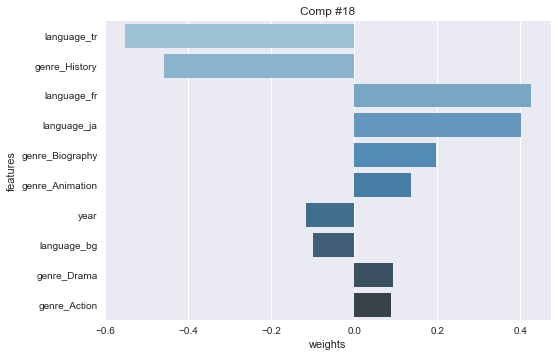

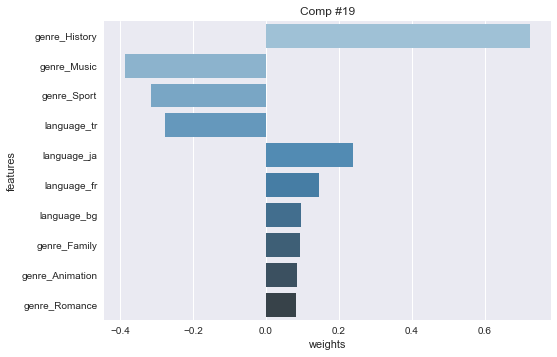

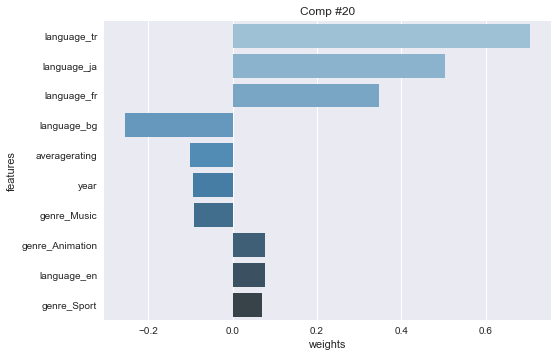

In [88]:
with plt.style.context('seaborn'):
    plt.suptitle('PCA Components Makeup')
    component_num = 1
    for i in range(5):
        for j in range(4):
            comps = pd.DataFrame(list(zip(v_20[20 - component_num], df_titles_scaled.columns)), columns=['weights', 'features'])
            comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
            axes = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
            axes.set_title("Comp #"+str(component_num))
            component_num += 1
            plt.show() 
          

In [89]:
#Will need to review this as the data will change over time
PCA_list=['Romance/Drama', 'Crime/Action/Thriller', 'Adventure/Drama', 'Horror/Mystery',
          'Action/Romance', 'Thriller/Romance', 'Fantasy', 'Romance/Mystery/Crime', 'Mystery/Drama/Comedy',
          'Sci-Fi/Fantasy', 'Mystery/Bio', 'Non-EN-Lang', 'Recent/Bio/Adventure', 
          'Classics', 'Recent/Fantasy/Animation', 'JA-Lang/TR-Lang', 'TR-Lang/Bio',
          'Bio/Older/FR-Lang', 'Music/Sport', 'History']

In [90]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 477 ms, sys: 52.5 ms, total: 529 ms
Wall time: 9min 34s


In [91]:
%%time
result = pca_predictor.predict(train_data)
df_titles_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    df_titles_transformed=df_titles_transformed.append([list(b)])
df_titles_transformed.index=df_titles_scaled.index
df_titles_transformed=df_titles_transformed.iloc[:,75:]
df_titles_transformed.columns=PCA_list

ValueError: Length mismatch: Expected axis has 19 elements, new values have 20 elements

In [92]:
df_titles_transformed.head()

,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
tt0035423 Kate & Leopold,0.083166,0.018514,0.045398,-0.089980,0.209642,0.096534,0.254310,0.055838,0.215915,0.157881,-0.319986,0.288021,0.825852,-0.036894,0.496419,0.107196,-0.322604,-1.049172,0.112972
tt0054698 Breakfast at Tiffany's,0.106838,0.129371,0.227621,-0.313195,-0.062628,0.625026,-0.144195,0.094375,-0.141698,0.007536,-0.013403,0.273485,-0.006954,0.274135,0.526199,-0.090748,0.148375,-0.733818,0.826988
tt0054997 The Hustler,-0.343806,0.116994,-0.077598,0.147979,-0.130963,0.720643,-0.412771,-0.878625,0.112262,0.096851,-0.111432,-0.259394,-0.094852,0.007292,-0.108712,0.186222,0.323741,0.194868,0.641751
tt0055031 Judgment at Nuremberg,0.014865,-0.013724,-0.044840,0.035439,-0.073448,0.818369,-0.422898,-0.914654,0.075384,0.133331,-0.086576,-0.208677,-0.091998,0.030238,-0.107860,0.193246,0.343685,0.219049,0.643023
tt0055254 One Hundred and One Dalmatians,0.077905,0.123487,0.153299,-0.261105,0.430824,0.460221,-0.319158,0.090144,-0.159339,-0.079892,-0.062546,0.134864,-0.330216,0.309548,-0.701429,0.105706,0.105062,-1.033597,-0.536424


In [93]:
train_data = df_titles_transformed.values.astype('float32')

In [94]:
#If the number of clusters is high, hopefully we get better recommendations
num_clusters = 40
kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/titles/',              
                k=num_clusters)

In [95]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-12 04:33:40 Starting - Starting the training job...
2020-11-12 04:33:41 Starting - Launching requested ML instances......
2020-11-12 04:34:47 Starting - Preparing the instances for training......
2020-11-12 04:36:09 Downloading - Downloading input data
2020-11-12 04:36:09 Training - Downloading the training image...
2020-11-12 04:36:41 Uploading - Uploading generated training model
2020-11-12 04:36:41 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/12/2020 04:36:31 INFO 139957529290560] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_t

[11/12/2020 04:36:33 INFO 139957529290560] TOTAL took: 0.0705299377441
[11/12/2020 04:36:33 INFO 139957529290560] Number of GPUs being used: 0
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 1029.803991317749, "sum": 1029.803991317749, "min": 1029.803991317749}, "initialize.time": {"count": 1, "max": 101.84383392333984, "sum": 101.84383392333984, "min": 101.84383392333984}, "model.serialize.time": {"count": 1, "max": 0.14090538024902344, "sum": 0.14090538024902344, "min": 0.14090538024902344}, "update.time": {"count": 1, "max": 64.73302841186523, "sum": 64.73302841186523, "min": 64.73302841186523}, "epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "state.serialize.time": {"count": 1, "max": 1.3191699981689453, "sum": 1.3191699981689453, "min": 1.3191699981689453}, "_shrink.time": {"count": 1, "max": 1027.5988578796387, "sum": 1027.5988578796387, "min": 1027.5988578796387}}, "EndTime": 1605155793.022962, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorit

In [96]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 466 ms, sys: 58.4 ms, total: 524 ms
Wall time: 9min 34s


In [97]:
%%time
result=kmeans_predictor.predict(train_data)

CPU times: user 194 ms, sys: 12.6 ms, total: 207 ms
Wall time: 1.99 s


In [98]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

11.0    187
4.0     177
5.0     166
14.0    159
25.0    152
24.0    128
10.0    127
6.0     124
3.0     119
7.0     113
23.0    102
8.0      93
22.0     85
27.0     85
18.0     82
15.0     79
9.0      76
12.0     75
2.0      69
28.0     68
36.0     66
32.0     65
26.0     65
0.0      63
33.0     58
1.0      58
13.0     56
16.0     55
34.0     49
29.0     47
20.0     46
30.0     39
21.0     38
38.0     36
37.0     34
31.0     33
39.0     31
35.0     29
19.0     27
17.0     26
Name: 0, dtype: int64

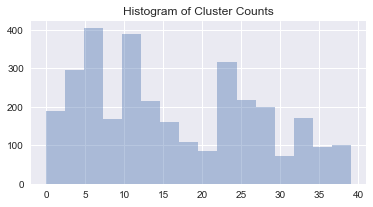

In [99]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

## Drawing conclusions from our modelling

In [100]:
#job_name='<your_SageMaker_KMeans_job_name_here>'
job_name=kmeans._current_job_name

model_key = "titles/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [101]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=df_titles_transformed.columns
cluster_centroids

,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,-0.035536,0.038641,0.002293,0.008274,-0.150681,0.018038,0.053559,0.011930,-0.223410,-0.078087,0.398784,0.061367,0.000664,0.163559,-0.012594,-0.008225,0.944289,0.383240,-0.406044
1,0.012026,-0.035666,-0.031644,0.027364,-0.028089,0.039646,0.141958,0.035190,0.024716,0.010689,-0.208081,0.121916,-0.101591,-0.168854,-0.405105,-0.748617,-0.613197,-0.516740,0.026582
2,-0.001338,0.025316,0.028618,-0.017661,-0.038229,-0.021086,0.090850,-0.036169,-0.517895,-0.077153,-0.175129,-0.250449,0.017424,0.181118,-0.032978,0.700113,-0.936933,0.398125,-0.095930
3,0.021703,-0.016828,-0.034982,0.022005,-0.036703,-0.006523,0.013837,-0.028678,0.113920,-0.199991,-0.237305,0.309628,0.138882,0.113008,0.557106,-0.046986,-0.375697,-0.983498,0.148158
4,-0.069847,-0.104129,-0.131832,0.184289,-0.024978,0.129272,-0.210468,-0.031840,-0.019108,0.068279,-0.007325,-0.099549,-0.055956,-0.007620,-0.106746,0.227496,0.326616,0.194219,0.537410
5,0.013712,0.052706,0.048936,-0.082324,0.001242,-0.036288,0.202467,0.103327,0.306228,-0.464809,-0.278719,-0.553806,-0.105804,-0.042772,-0.130839,0.109280,0.439447,0.179761,0.614760
6,-0.005133,-0.017894,-0.019408,0.015928,-0.044404,-0.000770,0.145083,0.015101,0.014703,0.247737,-0.270845,0.148350,-0.496642,-0.243433,0.253481,0.189420,0.474119,0.205294,-1.170477
7,0.033488,0.039554,0.031607,-0.075980,0.503150,-0.121565,-0.165922,-0.014614,-0.136791,-0.119753,0.015201,0.151801,-0.301320,0.306564,-0.679714,0.140308,0.190423,-0.908392,-0.489959
8,-0.002026,0.019437,0.017195,-0.015260,0.028508,-0.055746,-0.156225,-0.070037,-0.163834,-0.013695,0.145274,0.093733,0.139390,-0.303009,0.056883,-0.867276,0.259448,0.747528,0.109058
9,0.009188,-0.009859,-0.007863,-0.013959,0.026848,-0.024206,-0.036761,0.008172,-0.000224,-0.029704,-0.191797,0.056068,0.158745,0.287418,0.004708,-0.692149,-0.740019,0.817662,-0.501688


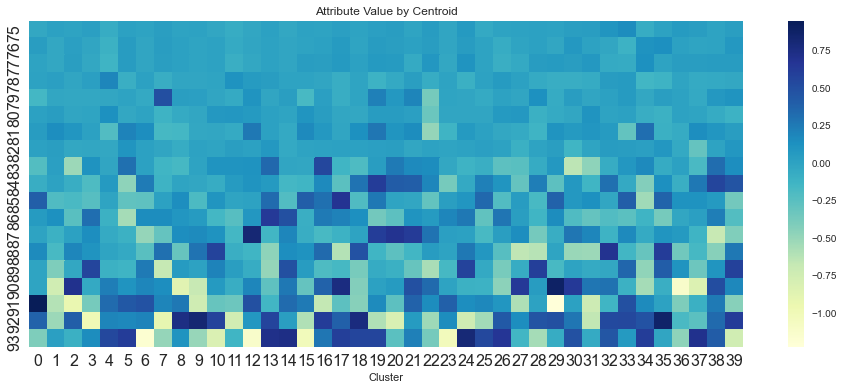

In [102]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [103]:
df_titles_transformed['labels']=list(map(int, cluster_labels))
df_titles_transformed.head()

,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,labels
tt0035423 Kate & Leopold,0.083166,0.018514,0.045398,-0.089980,0.209642,0.096534,0.254310,0.055838,0.215915,0.157881,-0.319986,0.288021,0.825852,-0.036894,0.496419,0.107196,-0.322604,-1.049172,0.112972,3
tt0054698 Breakfast at Tiffany's,0.106838,0.129371,0.227621,-0.313195,-0.062628,0.625026,-0.144195,0.094375,-0.141698,0.007536,-0.013403,0.273485,-0.006954,0.274135,0.526199,-0.090748,0.148375,-0.733818,0.826988,24
tt0054997 The Hustler,-0.343806,0.116994,-0.077598,0.147979,-0.130963,0.720643,-0.412771,-0.878625,0.112262,0.096851,-0.111432,-0.259394,-0.094852,0.007292,-0.108712,0.186222,0.323741,0.194868,0.641751,4
tt0055031 Judgment at Nuremberg,0.014865,-0.013724,-0.044840,0.035439,-0.073448,0.818369,-0.422898,-0.914654,0.075384,0.133331,-0.086576,-0.208677,-0.091998,0.030238,-0.107860,0.193246,0.343685,0.219049,0.643023,4
tt0055254 One Hundred and One Dalmatians,0.077905,0.123487,0.153299,-0.261105,0.430824,0.460221,-0.319158,0.090144,-0.159339,-0.079892,-0.062546,0.134864,-0.330216,0.309548,-0.701429,0.105706,0.105062,-1.033597,-0.536424,7


In [104]:
cluster=df_titles_transformed[df_titles_transformed['labels']==20]
cluster.sample(10)

,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,labels
tt0302640 The Hot Chick,0.000832,-0.029474,-0.045748,0.047140,0.183752,0.009936,0.250316,0.097816,0.219268,0.413669,-0.048888,-0.288061,0.679311,-0.263287,-0.040199,0.070669,-0.381661,-0.862546,-0.093750,20
tt0185431 Little Nicky,0.001661,-0.022225,-0.040436,0.041173,0.173382,0.010492,0.249059,0.099898,0.212557,0.415170,-0.047142,-0.286382,0.681881,-0.265888,-0.036476,0.071454,-0.389969,-0.866784,-0.098369,20
tt0101272 The Addams Family,0.006255,-0.013962,-0.002355,-0.016204,0.218152,0.290068,0.147111,0.109472,0.237346,0.431175,-0.105360,-0.296497,0.651838,-0.243871,-0.085207,0.070606,-0.349413,-0.850295,-0.062236,20
tt0170016 How the Grinch Stole Christmas,0.118286,0.074553,0.170885,-0.174733,-0.412602,-0.207260,-0.302213,-0.850202,0.520532,0.582642,-0.210826,-0.379332,0.764029,-0.227721,-0.223431,0.120901,-0.325538,-0.937258,-0.100317,20
tt9484998 Palm Springs,0.166570,0.396299,0.400845,0.645091,0.268301,0.022587,0.299636,0.202397,0.814267,0.332668,0.482475,0.114255,0.500338,-0.476279,-0.203683,0.283135,-0.549194,-0.724066,0.001666,20
tt0322330 Freaky Friday,0.088094,0.037547,0.132960,-0.143388,-0.364640,-0.289072,-0.311217,0.121298,0.363560,0.566602,-0.208290,-0.317722,0.802666,-0.248746,-0.211227,0.135559,-0.333127,-0.931200,-0.104997,20
tt0107120 Hocus Pocus,0.096098,0.054474,0.167315,-0.192631,-0.358594,-0.093849,-0.380650,0.132276,0.369112,0.579334,-0.244918,-0.321975,0.788085,-0.238420,-0.236506,0.136014,-0.318033,-0.925392,-0.087835,20
tt1222817 Zookeeper,0.179912,-0.074576,0.060459,-0.087814,-0.398058,-0.519736,-0.231609,0.137768,0.318360,0.541548,-0.169970,-0.293333,0.821405,-0.270091,-0.160551,0.134371,-0.351969,-0.943835,-0.126616,20
"tt0158983 South Park: Bigger, Longer & Uncut",0.076237,0.105782,0.081458,-0.176559,0.968807,0.013266,-0.269236,0.069539,0.189631,0.317803,-0.140729,-0.222846,0.532718,-0.115579,-0.371397,0.112386,-0.271655,-0.960994,-0.118453,20
tt1289401 Ghostbusters,0.027042,0.022377,0.017643,-0.059969,0.300655,-0.050089,0.124372,0.092791,0.282423,0.285015,0.278343,-0.442498,0.790414,-0.315921,0.378793,-0.295427,-0.137581,-0.533828,-0.608820,20


In [105]:
# merge the title info and ratings data frames on the title id field
df_titles_clustered = pd.merge(left=df_titles, right=df_titles_transformed, left_index=True, right_index=True)

In [106]:
df_titles_clustered.to_csv("clustered_titles.csv")

In [107]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [108]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [109]:
boto3.resource('s3').Bucket(bucket_name).upload_file("clustered_titles.csv", "titles/clustered_titles.csv")